At present Oct 2022, after Martha updated the NIRCam photometric zeropoints, this is plotting the latest reduction of the NIRCam data.
TODO:
- Add in the re-reduced NIRISS data
- Add in Maca's latest reduction of the MIRI data

For NIRCam, rather than worry about what photometric calibration was applied, I am just using the RATE files, and applying a calibration later.

In [119]:
import jrr    #https://github.com/janerigby/jrr
from os.path import basename
from os import getcwd
import glob
import numpy as np
import astropy
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from astropy.time import Time
from astropy import constants
from astropy import units
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler
import pandas
from re import sub, split
from celluloid import Camera
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 22})

In [120]:
whos_fluxing = 'martha2'  # Whose fluxing should we use?

fluxing_dicts = {'marcia'  : jrr.jwst.get_mrieke_fluxcal_aug2022(), \
                 'marcia2' : jrr.jwst.get_mrieke_fluxcal_sept2022(), \
                 'gabe'    : jrr.jwst.get_gbrammer_fluxcal_aug2022(), \
                 'martha2' : jrr.jwst.get_mboyer_fluxcal_sep202022_justdict()} #sept 20 2022 update
redo_phot = False   # It is time consuming to redo all the photometry.  Only do this if something changed
repredict_backgrounds = False

In [121]:
def from_PID_observtn_to_prefix(pid, observtn) :
    return('jw' + pid + str(observtn).zfill(3))

def get_observtn_from_prefix(prefix) :
    return(int(prefix[-3:]))

def find_obsname_from_observtn(observtn, dict_obs):
    for observation_name2, observations2 in (sorted(dict_obs.items(), key=lambda x:x[1])):
        if observtn in observations2 : 
            return(observations2, observation_name2)

In [122]:
def group_the_df(df, statcol='median'):
    grouped = df.groupby(by=['detector', 'filtername', 'observtn']).median().reset_index()
    std_of_grouped = df.groupby(by=['detector', 'filtername', 'observtn']).std().reset_index()
    grouped[statcol + '_std'] = std_of_grouped[statcol]  # Grab standard dev, and put it in grouped
    grouped['shortdet'] = grouped['detector'].str.replace('NRC', '').str.replace('MIRIMAGE', 'MIRI')
    grouped.loc[grouped.detector == 'NRCB1'].tail()
    grouped.tail()
    
    # again, but combine all NIRCam detectors together
    grouped2 = df.groupby(by=['instrument', 'filtername', 'observtn']).median().reset_index() 
    std_of_grouped = df.groupby(by=['instrument', 'filtername', 'observtn']).std().reset_index()
    grouped2[statcol + '_std'] = std_of_grouped[statcol]  # Grab standard dev, and put it in grouped
    #grouped2.loc[(grouped2.instrument == 'NIRCAM') & (grouped2.filtername == 'F200W')].head(10)
    return(grouped, grouped2)

In [123]:
#commiss_drive = '/Volumes/JWST_Commissioning/Commis_data/'
commiss_drive  = '/Users/jrrigby1/SCIENCE/JWST_Data/Commis_data/'

In [124]:
nirspecdir = commiss_drive + 'Stray_Light/From_NIRSpec/'  #  THIS IS OLD
regfile = commiss_drive + 'Stray_light/L3/miri_valid_box.reg'
savefiles_prefix = 'PID1448-L2'

In [125]:
# Data where I want to use the RATE files:
# For NIRCam, use JRR's re-reduction from early Sept 2022, **the RATE files (DN/s)**
nircam_indir  = commiss_drive + "Stray_light_reprocess/NIRCam/L2a/"

# For MIRI, use Maca's re-reduction of 11 Sept 2022.       ** CAL files (MJy/sr)**
miri_indir    = commiss_drive + "Stray_light_reprocess/MIRI/"

# For NIRISS, use JRR's re-reduction from early Sept 2022, **the CAL files (MJy/sr)**
niriss_indir  = commiss_drive + "Stray_light_reprocess/NIRISS/L2b/"

savefiles_prefix = 'PID1448-L2-repro-'

In [126]:
# Email from Erin May 9 explains which observtns are which
# This is a cleaner way to store this
dict_obs = {'Galactic bulge': (1,9),  'Low bkg 1': (2, 12), 'LB2-EGS-N': (3, 13), \
            'Low bkg 3': (4, 14), '1.2 min zodi benchmark': (5, 15, 11), \
            'CVZ-S': (6, 16, 10), 'High Zodi': (7,), 'Moderate bkg': (8,)}
for observation_name2, observations2 in (sorted(dict_obs.items(), key=lambda x:x[1])):
    print(observations2, observation_name2)

(1, 9) Galactic bulge
(2, 12) Low bkg 1
(3, 13) LB2-EGS-N
(4, 14) Low bkg 3
(5, 15, 11) 1.2 min zodi benchmark
(6, 16, 10) CVZ-S
(7,) High Zodi
(8,) Moderate bkg


In [127]:
# search the dict of observations to get which one we're on
find_obsname_from_observtn(5, dict_obs)

((5, 15, 11), '1.2 min zodi benchmark')

In [128]:
# Translate filter names to approx wavelengths
filter_wave = jrr.jwst.getwave_for_filter()
filter_width = jrr.jwst.getwidth_for_filter()

In [129]:
filterfile = '/Users/jrrigby1/Python/jrr/jwst_filters.txt'
df_filters = pandas.read_csv(filterfile, delim_whitespace=True, comment='#')
df_filters.head()

,instrument,filtname,wavelength,width,eff_response,blue_wave,red_wave
0,NIRCAM,F070W,0.704,0.132,0.200,0.621,0.781
1,NIRCAM,F090W,0.902,0.194,0.292,0.795,1.005
2,NIRCAM,F115W,1.154,0.225,0.325,1.013,1.282
3,NIRCAM,F140M,1.405,0.142,0.397,1.331,1.479
4,NIRCAM,F150W,1.501,0.318,0.422,1.331,1.668


In [130]:
filenames_nircam = [x for x in glob.glob(nircam_indir + "*rate.fits") ]
filenames_niriss = [x for x in glob.glob(niriss_indir + "*cal.fits") ]
filenames_miri = [x for x in glob.glob(miri_indir + "*/*cal.fits") ]
filenames_to_process_as_rates = filenames_nircam
filenames_to_process_as_cal   = filenames_miri + filenames_niriss

In [131]:
# Next cell measures all the RATE files (DN/s)

In [132]:
%%capture cap
if redo_phot :  # Only redo photometry if needed, bc this step is slow
    clip_sigma = 1 ; clip_grow = 0; clip_maxiters=4  # for sigma clipped median
    print('filtername', 'wave', 'filtwidth', 'date', 'detector', 'x', 'y', 'median', 'median_clipped', 'filename', 'observtn', 'visit', 'instrument')
    # above is cute magic to print out what's in this cell with nice print formatting
    for thisfile in (filenames_to_process_as_rates):  # file has mulitple headers, so do the long HDU way
        hdu = fits.open(thisfile)
        instrument = hdu[0].header['INSTRUME']
        if 'NIRISS' in instrument: filter    = hdu[0].header['pupil']
        else : filter = hdu[0].header['filter']
        median = jrr.util.median_ignore_zero(hdu[1].data)
        (mean, median_clip, stddev) = sigma_clipped_stats(hdu[1].data, maxiters=clip_maxiters, sigma=clip_sigma, grow=clip_grow)
        date_beg = hdu[0].header['date-beg']+'Z' # force zulu to make pandas happy
        print(filter, filter_wave[filter], filter_width[filter], date_beg, hdu[0].header['DETECTOR'], \
            hdu[1].data.shape[0], hdu[1].data.shape[1], median, median_clip, basename(thisfile), \
              hdu[0].header['OBSERVTN'], hdu[0].header['VISIT'], instrument)

In [133]:
statsfile1 = savefiles_prefix + "-backgrounds_rates.txt"
if redo_phot: 
    with open(statsfile1, 'w') as f:
        f.write(cap.stdout)

In [134]:
# Apply fluxing to the rate files
df1 = pandas.read_csv(statsfile1, delim_whitespace=True)
thisfluxing_dict = fluxing_dicts[whos_fluxing]  # load the fluxing dictionary 
df1['dummycol'] = df1['filtername'] + '_' + df1['detector']
df1['PHOTMJSR'] = df1['dummycol'].map(thisfluxing_dict)
df1['sb_mjsr'] = df1['median'] * df1['PHOTMJSR']
df1.drop('dummycol', inplace=True, axis=1)
df1.head()

,filtername,wave,filtwidth,date,detector,x,y,median,median_clipped,filename,observtn,visit,instrument,PHOTMJSR,sb_mjsr
0,F200W,1.989,0.457,2022-04-29T11:40:41.486Z,NRCB4,2048,2048,0.216728,0.215908,jw01448007001_04101_00001_nrcb4_rate.fits,7,1,NIRCAM,1.7715,0.383934
1,F150W,1.501,0.318,2022-05-06T00:34:09.838Z,NRCB2,2048,2048,0.062142,0.061627,jw01448003001_08101_00002_nrcb2_rate.fits,3,1,NIRCAM,2.3054,0.143261
2,F356W,3.568,0.781,2022-05-06T03:15:29.381Z,NRCBLONG,2048,2048,0.275142,0.272999,jw01448004001_06101_00001_nrcblong_rate.fits,4,1,NIRCAM,0.3760,0.103453
3,F115W,1.154,0.225,2022-05-03T00:42:20.075Z,NRCB1,2048,2048,0.066306,0.065462,jw01448005001_06101_00002_nrcb1_rate.fits,5,1,NIRCAM,3.2719,0.216946
4,F115W,1.154,0.225,2022-05-06T03:15:29.381Z,NRCB4,2048,2048,0.085919,0.085273,jw01448004001_06101_00001_nrcb4_rate.fits,4,1,NIRCAM,2.6985,0.231851


In [135]:
# Next cell measures all the FLUXED CAL files (MJy/SR)

In [136]:
%%capture cap 
if redo_phot:
    clip_sigma = 1 ; clip_grow = 0; clip_maxiters=4  # for sigma clipped median
    print('filtername', 'wave', 'filtwidth', 'date', 'detector', 'x', 'y', 'median', 'median_clipped', 'filename', 'observtn', 'visit', 'instrument')
    for thisfile in (filenames_to_process_as_cal):  # file has mulitple headers, so do the long HDU way
        hdu = fits.open(thisfile)
        instrument = hdu[0].header['INSTRUME']
        if 'NIRISS' in instrument: filter    = hdu[0].header['pupil']
        else : filter = hdu[0].header['filter']

        if 'MIRI' in instrument :
            label = 'foo'
            foo = jrr.phot.wrap_simple_region_photometry(thisfile, regfile, prefix=label, override_label=basename(thisfile), \
                  clip_sigma=clip_sigma, clip_grow=clip_grow, clip_maxiters=clip_maxiters)
            median      = (foo[label + 'median']).values[0]
            median_clip = (foo[label + 'clipped_median']).values[0]
        else :
            median = np.median(hdu[1].data) # Sub in a better metric later
            (mean, median_clip, stddev) = sigma_clipped_stats(hdu[1].data, maxiters=clip_maxiters, sigma=clip_sigma, grow=clip_grow)
        date_beg = hdu[0].header['date-beg']+'Z' # force zulu to make pandas happy
        print(filter, filter_wave[filter], filter_width[filter], date_beg, hdu[0].header['DETECTOR'], \
            hdu[1].data.shape[0], hdu[1].data.shape[1], median, median_clip, basename(thisfile), \
              hdu[0].header['OBSERVTN'], hdu[0].header['VISIT'], instrument)

In [137]:
statsfile2 = savefiles_prefix +  "-backgrounds_cal.txt"
if redo_phot:
    with open(statsfile2, 'w') as f:
        f.write(cap.stdout)

In [138]:
df2 = pandas.read_csv(statsfile2, delim_whitespace=True)  # Read the calibrated files.  
df2['sb_mjsr'] = df2['median'] #Already in MJy/sr units
df2.tail()

,filtername,wave,filtwidth,date,detector,x,y,median,median_clipped,filename,observtn,visit,instrument,sb_mjsr
101,F115W,1.154,0.225,2022-05-06T03:56:24.598Z,NIS,2048,2048,0.184267,0.183176,jw01448014001_02101_00001_nis_cal.fits,14,1,NIRISS,0.184267
102,F200W,1.989,0.457,2022-05-06T10:44:06.846Z,NIS,2048,2048,0.133333,0.131809,jw01448016001_02106_00001_nis_cal.fits,16,1,NIRISS,0.133333
103,F200W,1.989,0.457,2022-05-06T01:31:43.071Z,NIS,2048,2048,0.126377,0.125740,jw01448013001_02106_00001_nis_cal.fits,13,1,NIRISS,0.126377
104,F115W,1.154,0.225,2022-05-03T04:59:00.816Z,NIS,2048,2048,0.183598,0.181875,jw01448015001_02101_00001_nis_cal.fits,15,1,NIRISS,0.183598
105,F200W,1.989,0.457,2022-04-29T08:20:37.965Z,NIS,2048,2048,0.139583,0.138874,jw01448012001_02106_00001_nis_cal.fits,12,1,NIRISS,0.139583


In [139]:
grouped1_df1, grouped2_df1 = group_the_df(df1, statcol='sb_mjsr')
grouped1_df2, grouped2_df2 = group_the_df(df2, statcol='sb_mjsr')

In [140]:
#jrr.jwst.getwidth_for_filter()
#df1['PHOTMJSR'] = df1['dummycol'].map(marcia_dict)

In [141]:
# Dump dataframes to files for record-keeping
df1.to_csv(savefiles_prefix + "-df1.txt", index=False)
df2.to_csv(savefiles_prefix + "-df2.txt", index=False)
grouped1_df1.to_csv(savefiles_prefix + "-df1-grouped.txt", index=False)
grouped1_df2.to_csv(savefiles_prefix + "-df2-grouped.txt", index=False)

In [142]:
#df.observtn.unique()
pid = '01448'
testit = ['jw' + pid + x.zfill(3) for x in df1.observtn.unique().astype('str')]
files_to_predict_bkg_from = {}
for thistest in testit:
    files_to_predict_bkg_from[thistest] = [x for x in filenames_to_process_as_rates if thistest in x][0]
#files_to_predict_bkg_from

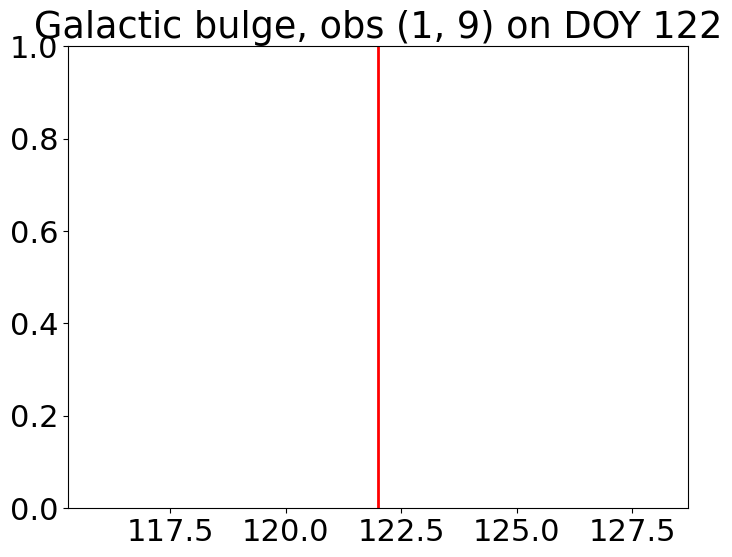

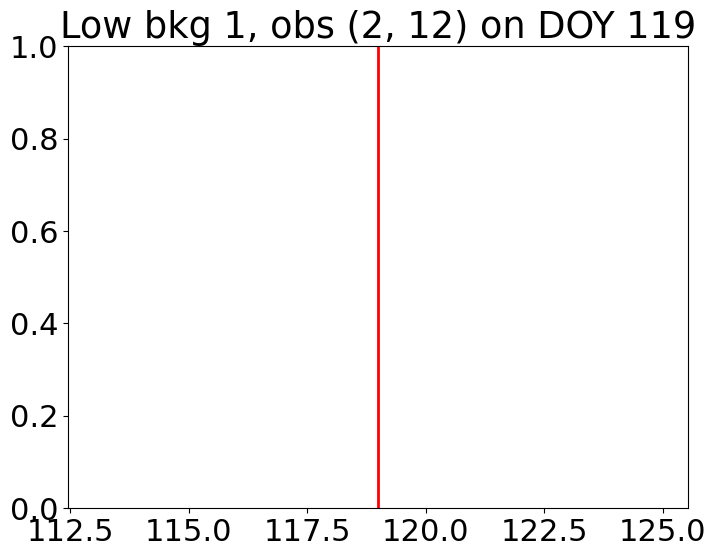

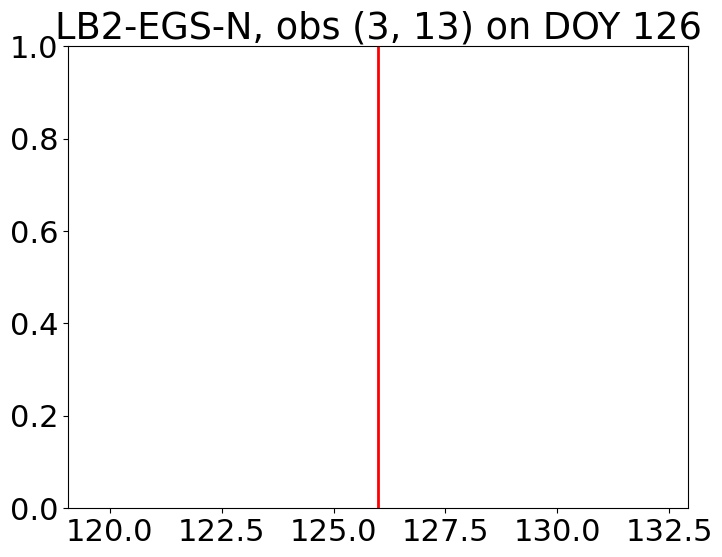

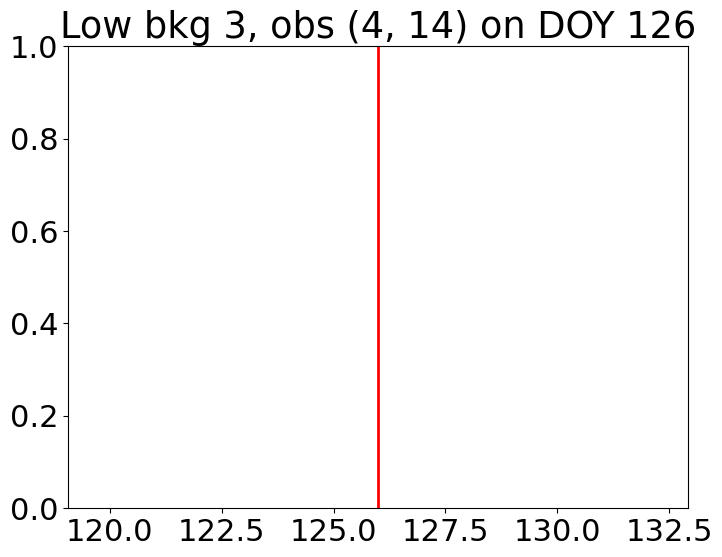

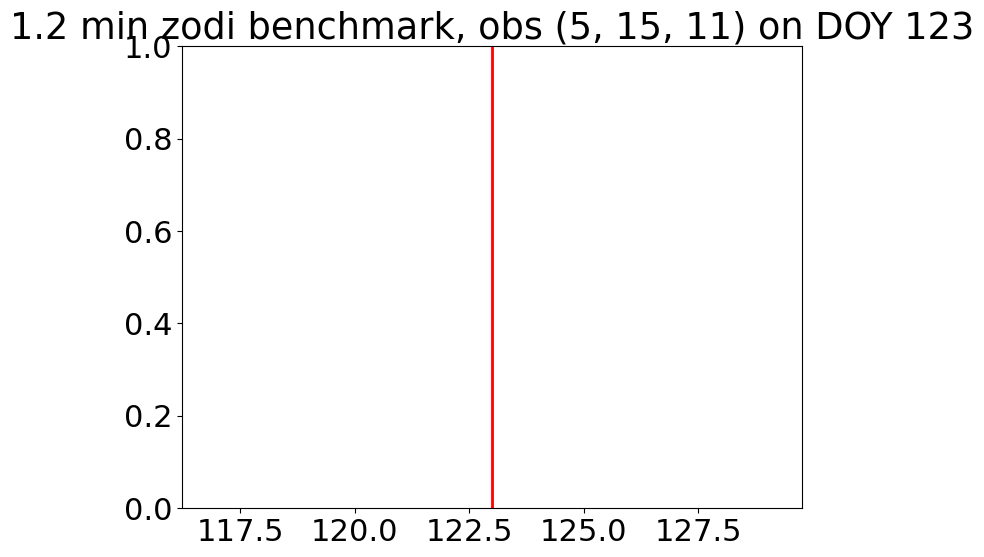

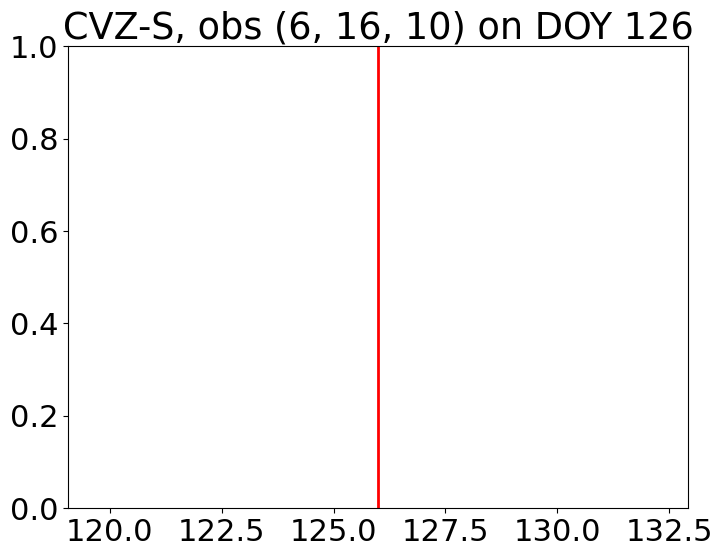

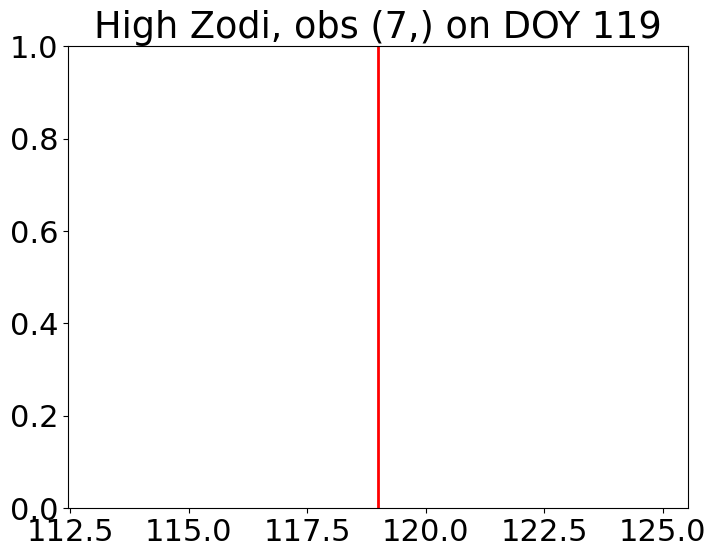

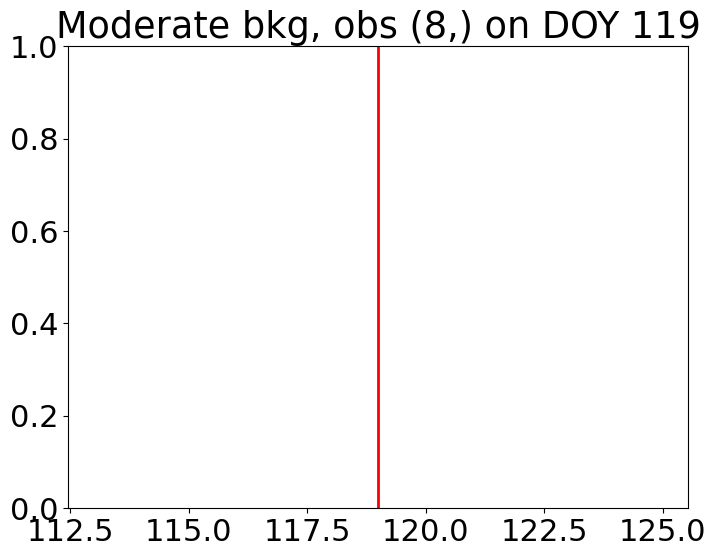

,wave,total,zody,Gal,straylight,thermal
0,0.5,1.0876,0.2534,0.7872,0.0469,0.0
1,0.6,1.5670,0.3349,1.1387,0.0934,0.0
2,0.7,1.7755,0.3760,1.3000,0.0995,0.0
3,0.8,1.9516,0.3881,1.4581,0.1054,0.0
4,0.9,1.8978,0.3812,1.4099,0.1067,0.0


In [143]:
the_pdf = 'straylightcar_bathtubs.pdf'
plt.rcParams['figure.figsize'] = [8, 6]
pp = PdfPages(the_pdf)  # output 
bkg_df = {}
for obsname, jwstfile in sorted(files_to_predict_bkg_from.items()):
    outfile = 'straylightcar_predictedbkg_visit' + obsname + '.txt'
    all_obs_in_this_field, fieldname = (find_obsname_from_observtn(get_observtn_from_prefix(obsname), dict_obs))
    (RA, DEC, DOY) = jrr.jwst.get_coords_dayofyear_from_jwstfile(jwstfile)
    if repredict_backgrounds:
        bkg_df[obsname] = jrr.jwst.get_background_for_jwstfile(jwstfile, bkg_file=outfile, plot_bathtub=True, showsubbkgs=False)
    else : 
        bkg_df[obsname] = jrr.jwst.open_background_file(outfile)
    plt.axvline(x=DOY, color='red', lw=2)
    title = fieldname + ", obs " + str(all_obs_in_this_field) + " on DOY " + str(DOY)
    plt.title(title)
    pp.savefig(bbox_inches='tight')
    plt.show()
pp.close()
bkg_df[obsname].head()

In [144]:
# Load NIRSpec MOS data from Pierre
nirspec_obsnum = (9, 10, 11)
suffix = '_COMM_median_spectrum_mos_uniform.json'
nirspec_files = [ nirspecdir + str(obsnum) + suffix for obsnum in nirspec_obsnum]
df_nirsp = {}
for thisobs in nirspec_obsnum :
    nirspec_file = nirspecdir + '/obs' + str(thisobs) + suffix 
    df_nirsp[thisobs] = pandas.read_json(nirspec_file)
    # I think Pierre's spectrum is in flambda surface brightness units, W/m2/m/arcsec^2
    # Convert to fnu
    df_nirsp[thisobs]['fnu_SB_SI'] = df_nirsp[thisobs]['data'] * (df_nirsp[thisobs]['wavelength'])**2 \
    / constants.c.si.value
    df_nirsp[thisobs]['fnu_SB_MJsr'] = df_nirsp[thisobs]['fnu_SB_SI'] /2.35044E-31
    df_nirsp[thisobs]['try2'] = df_nirsp[thisobs]['fnu_SB_SI'] / 1E-26 /1E6 / 2.35044E-11 
#    pierre_constants = (1e6 * 2.3504e-11) / (1e26  / constants.c.si)
#    df_nirsp[thisobs]['pierre_fnu'] = df_nirsp[thisobs]['data'] * pierre_constants / df_nirsp[thisobs]['wavelength']**2 
    #df_nirsp[thisobs].plot(x='wavelength', y='try2')
df_nirsp[thisobs].head(2)

,author,data,description,file_type,file_version,reference,units,wavelength,fnu_SB_SI,fnu_SB_MJsr,try2
0,plot_backgrounds.py - version 1.0.1,2.479327e-11,calibrated median background spectrum for 872_...,SRC,1.0.0,obs11 - 872_COMM,W m-3 arcsec-2,6.150000e-07,3.127975e-32,0.13308,0.13308
1,plot_backgrounds.py - version 1.0.1,2.410168e-11,calibrated median background spectrum for 872_...,SRC,1.0.0,obs11 - 872_COMM,W m-3 arcsec-2,6.200000e-07,3.090367e-32,0.13148,0.13148


In [145]:
#for thisthisobs in nirspec_obsnum :
#    plt.plot(df_nirsp[thisthisobs].wavelength, df_nirsp[thisthisobs].fnu_SB_MJsr, label='NIRSpec'+str(thisthisobs))
#plt.legend()

In [146]:
print("Executed these observations:", df1.observtn.unique(), df2.observtn.unique())
print("Computed backgrounds for these observations: ", bkg_df.keys())

Executed these observations: [7 3 4 5 6 8 2 1] [ 1  6  5  2  3  4  7  8 14 13 16 15 12]
Computed backgrounds for these observations:  dict_keys(['jw01448001', 'jw01448002', 'jw01448003', 'jw01448004', 'jw01448005', 'jw01448006', 'jw01448007', 'jw01448008'])


In [147]:
dict_obs

{'Galactic bulge': (1, 9),
 'Low bkg 1': (2, 12),
 'LB2-EGS-N': (3, 13),
 'Low bkg 3': (4, 14),
 '1.2 min zodi benchmark': (5, 15, 11),
 'CVZ-S': (6, 16, 10),
 'High Zodi': (7,),
 'Moderate bkg': (8,)}

In [148]:
grouped1_df2.head()

,detector,filtername,observtn,wave,filtwidth,x,y,median,median_clipped,visit,sb_mjsr,sb_mjsr_std,shortdet
0,MIRIMAGE,F1000W,1,10.0,2.0,1024.0,1032.0,29.779579,29.548676,1.0,29.779579,0.010218,MIRI
1,MIRIMAGE,F1000W,2,10.0,2.0,1024.0,1032.0,13.091964,13.092088,1.0,13.091964,0.018925,MIRI
2,MIRIMAGE,F1000W,3,10.0,2.0,1024.0,1032.0,13.082744,13.087058,1.0,13.082744,0.021586,MIRI
3,MIRIMAGE,F1000W,4,10.0,2.0,1024.0,1032.0,12.767017,12.771955,1.0,12.767017,0.017750,MIRI
4,MIRIMAGE,F1000W,5,10.0,2.0,1024.0,1032.0,12.692144,12.695905,1.0,12.692144,0.015086,MIRI


In [149]:
def grab_subset_df(grouped_df, thisobs):    
    subset  = grouped_df.loc[grouped_df.observtn.isin(thisobs)]
    return(subset)

def plot_dfs_new(grouped1_df1, grouped1_df2, grouped2_df1, grouped2_df2, statcol='sb_mjsr', annotate=True):
    # grouped1 is for each detector, grouped2 is the median of all detectors
    # _df1 is measured from RATES (DN/s).   _df2 is measured from CAL (calibratd files, MJy/sr)
    df = grouped1_df1 ;  plt.scatter(df['wave'], df[statcol], color='k', s=30)  # Plot individual points per detector
    df = grouped1_df2 ;  plt.scatter(df['wave'], df[statcol], color='r', s=150)
    df = grouped2_df1 ;  plt.scatter(df['wave'], df[statcol], color='purple', marker='*', s=200) # Plot median over multiple detectors
    # grouped2_dfx has the median over multiple detectors.  This is only relevant for NIRCam, so do a subset
    df = grouped2_df2.loc[grouped2_df2['instrument'].eq('NIRCAM')] ;  plt.scatter(df['wave'], df[statcol], color='pink', marker='P', s=160)

    df = grouped1_df2.loc[grouped1_df2.detector.eq('MIRIMAGE')]
    plt.errorbar(df['wave'], df[statcol], xerr=df['filtwidth'] / 2.0, color='k', ls='none', capsize=10, lw=2)
    df.head()
    
    if annotate: 
        for df in (grouped1_df1, grouped1_df2):
            jrr.plot.annotate_from_dataframe(df, 'wave', statcol, 'shortdet', xytext=(-7,0), fontsize=14)
    return(0)

Galactic bulge (1, 9)


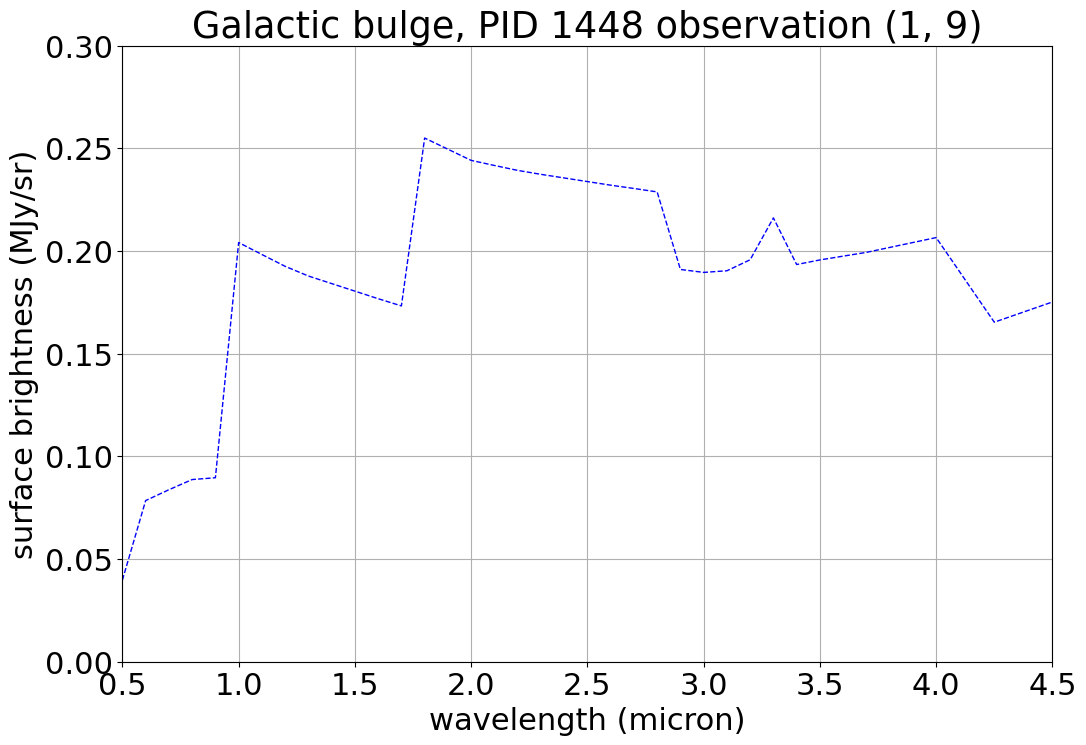

Low bkg 1 (2, 12)


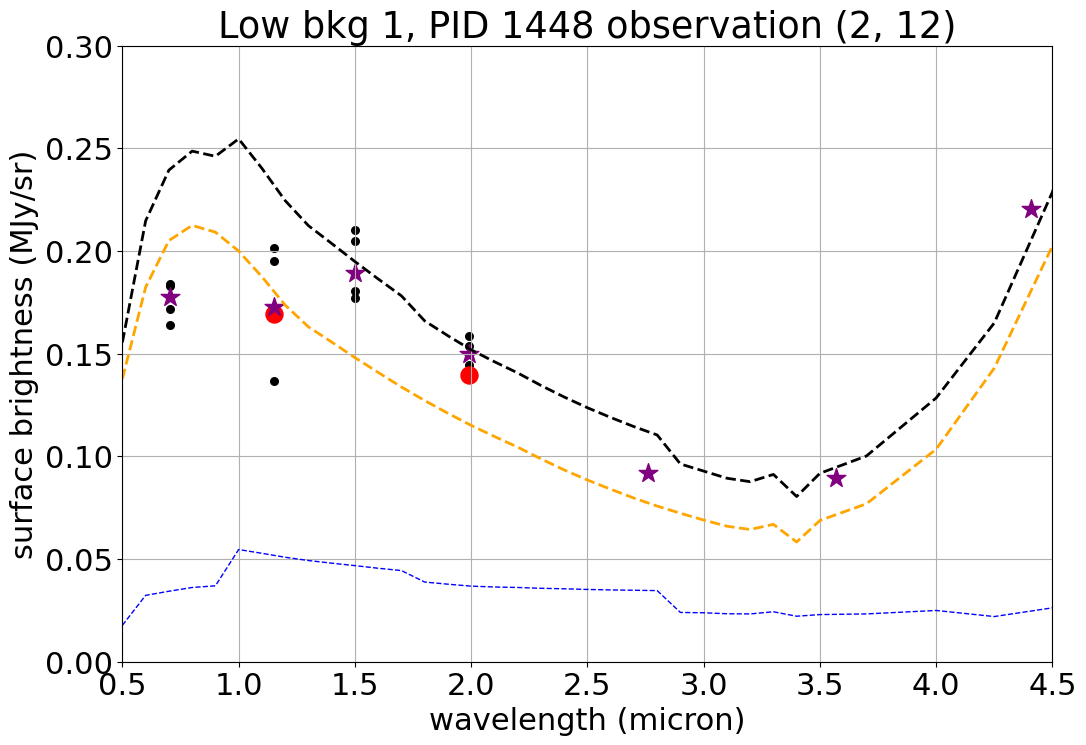

LB2-EGS-N (3, 13)


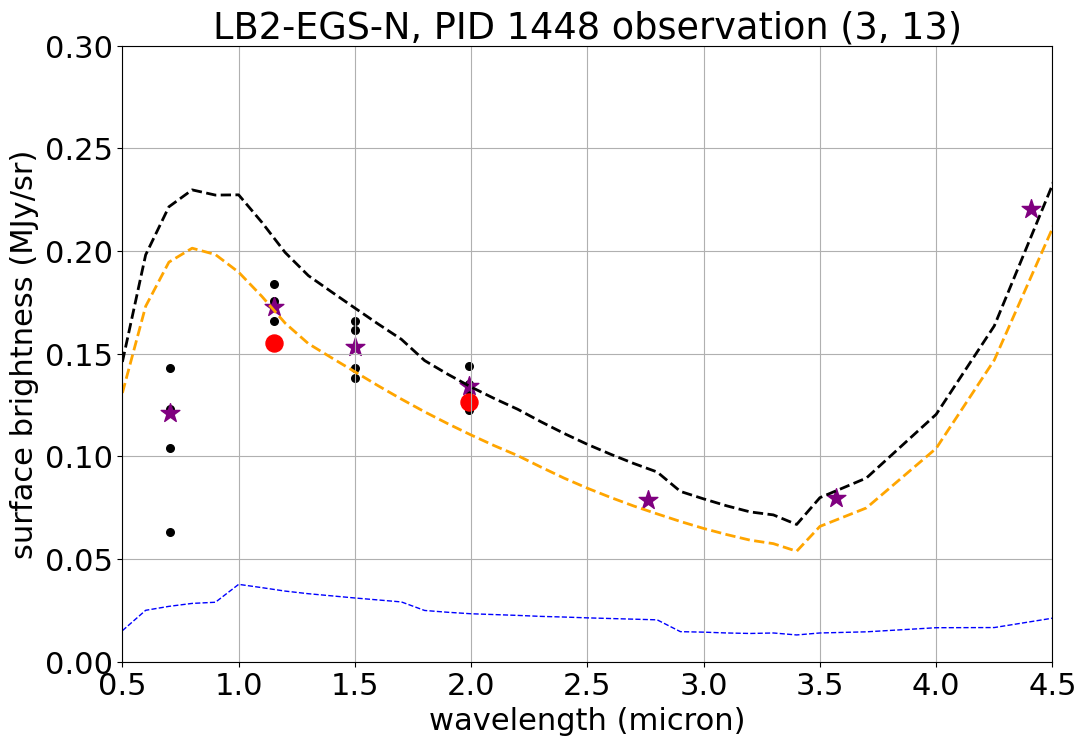

Low bkg 3 (4, 14)


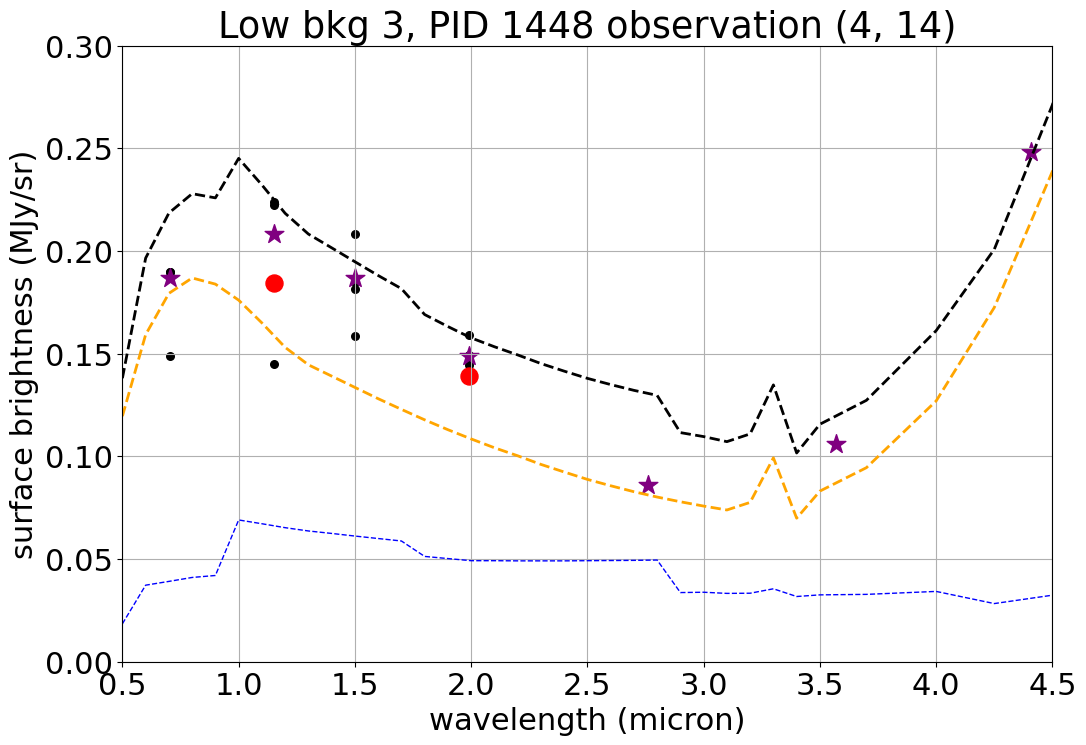

1.2 min zodi benchmark (5, 15, 11)


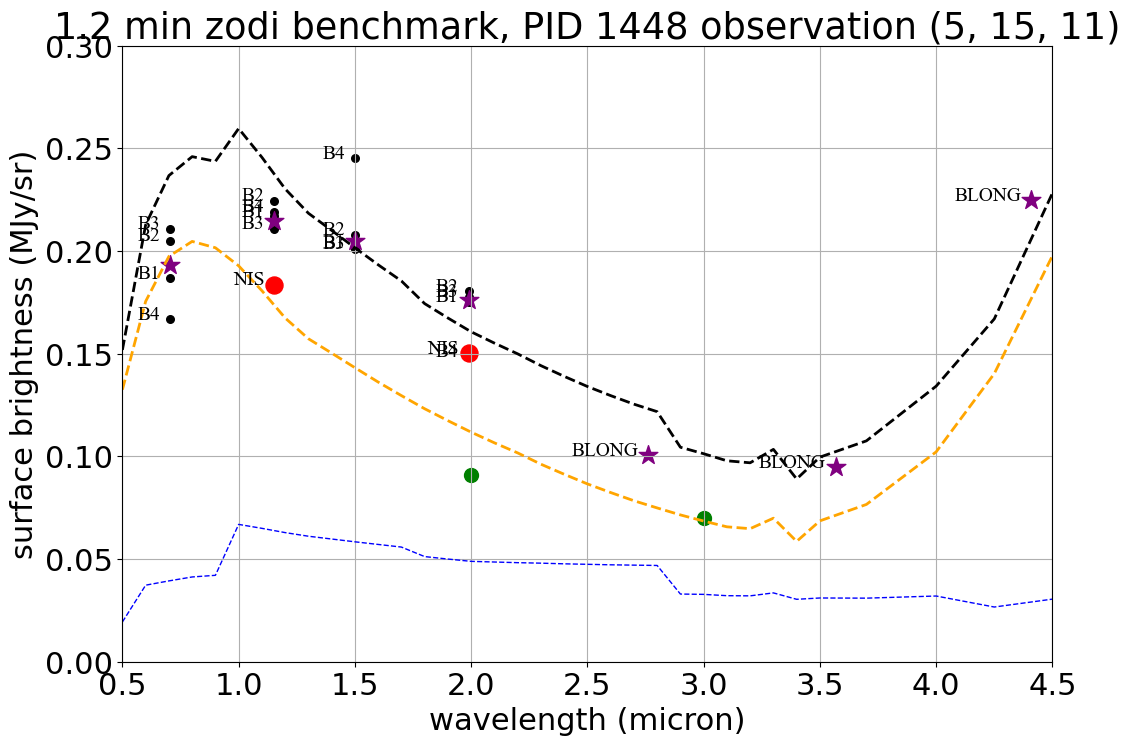

CVZ-S (6, 16, 10)


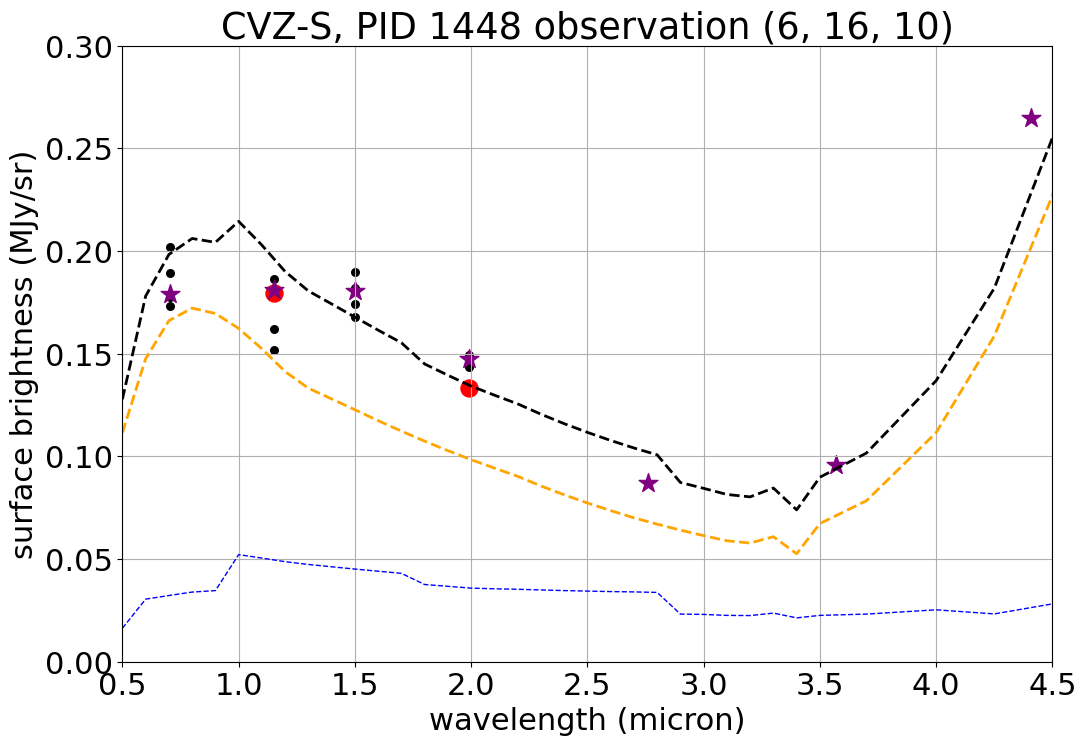

High Zodi (7,)


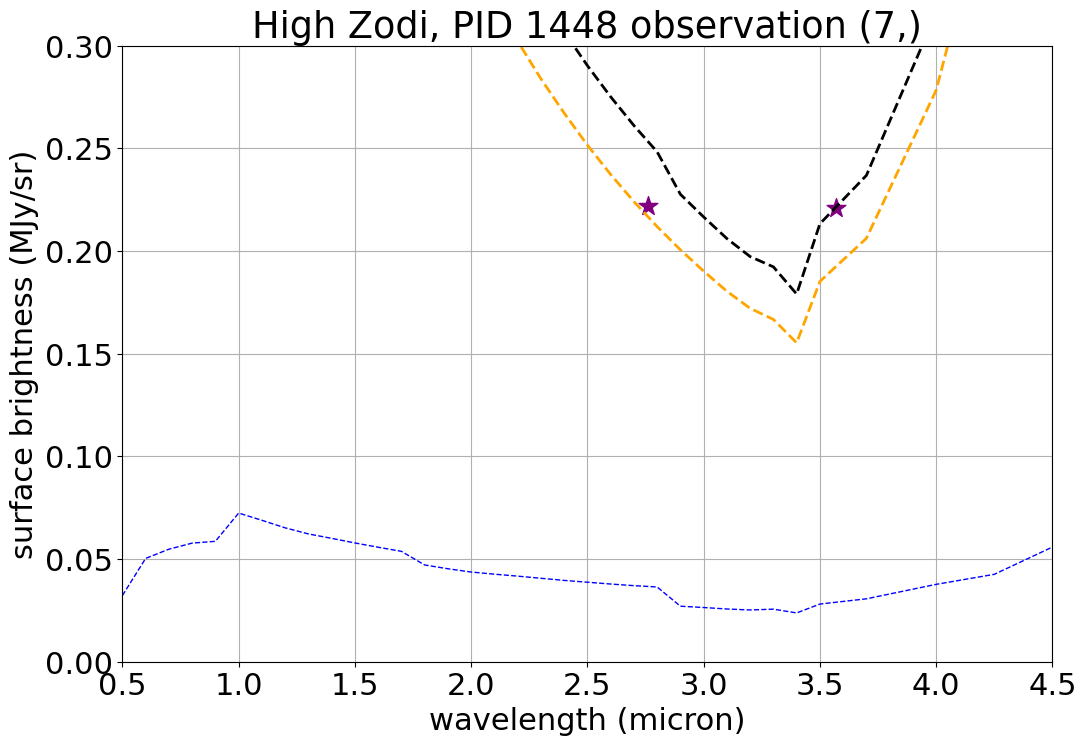

Moderate bkg (8,)


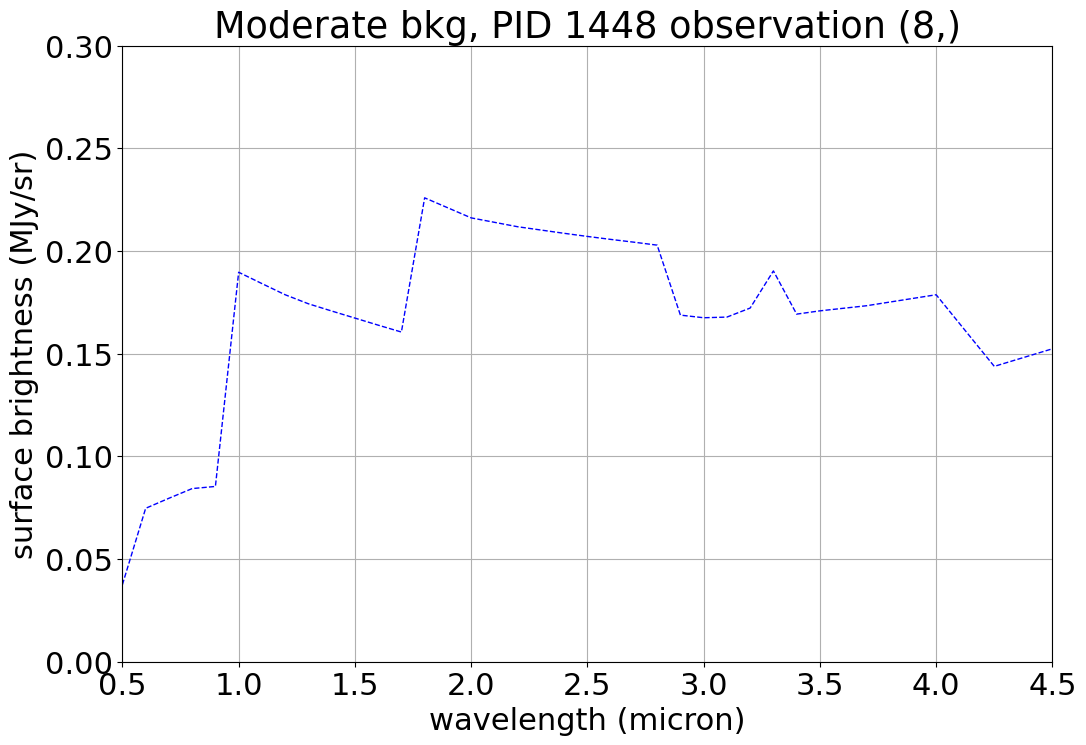

In [150]:
# PLOT EVERYTHING!
x1=0.5; x2=4.5
y1=0.0; y2=0.3 
the_pdf = 'straylightcar_NIR_lowbkg'
#
#x1=0.5; x2=4.5
#y1=0.0; y2=5
#the_pdf = 'straylightcar_NIR_highbkg'
##
#x1=0.5; x2=15
#y1=0.03; y2=160
#the_pdf = 'straylightcar_midIR'
##
#x1=0.5; x2=4.5
#y1=0.0; y2=1
#the_pdf = 'straylightcar_NIR_highzody'
#

the_pdf = the_pdf + whos_fluxing + '_fluxing.pdf'
plt.rcParams['figure.figsize'] = [12, 8]
pp = PdfPages(the_pdf)  # output 
# Loop over all the observations
statcol = 'sb_mjsr'
scale_straylight = 0.8  #  CAREFUL NOW!   
for thisobsname, thisobs in (sorted(dict_obs.items(), key=lambda x:x[1])):
    print(thisobsname, thisobs)
    sub1_1 = grab_subset_df(grouped1_df1, thisobs)
    sub1_2 = grab_subset_df(grouped1_df2, thisobs)
    sub2_1 = grab_subset_df(grouped2_df1, thisobs)
    sub2_2 = grab_subset_df(grouped2_df2, thisobs)
    if 'benchmark' in thisobsname : doannotate = True
    else : doannotate=False
    plot_dfs_new(sub1_1, sub1_2, sub2_1, sub2_2, statcol='sb_mjsr', annotate=doannotate)
    plt.title(thisobsname + ', observtn ' + str(thisobs) + " w " + whos_fluxing + \
              " flux calib, stray light scaled x" + str(scale_straylight))
    plt.title(thisobsname + ", PID 1448 observation " + str(thisobs))
    if 'benchmark' in (thisobsname) : 
        plt.scatter((2.0, 3.0), (0.091, 0.07), color='green', label='Stray light requirements', s=100)
    prefix = from_PID_observtn_to_prefix(pid, thisobs[0]) 
    jrr.jwst.plot_expected_bkgs(bkg_df[prefix], scalestray=scale_straylight, plotlegend=False, plotall=True)
    plt.xlim(x1, x2)
    plt.ylim(y1, y2) 
    #plt.yscale('log')
    plt.xlabel("wavelength (micron)")
    plt.ylabel("surface brightness (MJy/sr)")
    pp.savefig()
    plt.show()
pp.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


1.2 min zodi benchmark (5, 15, 11)
0.0
0.10714285714285714
0.21428571428571427
0.3214285714285714
0.42857142857142855
0.5357142857142857
0.6428571428571428
0.75
0.8571428571428571
0.9642857142857142
1.0714285714285714
1.1785714285714286
1.2857142857142856
1.3928571428571428
1.5


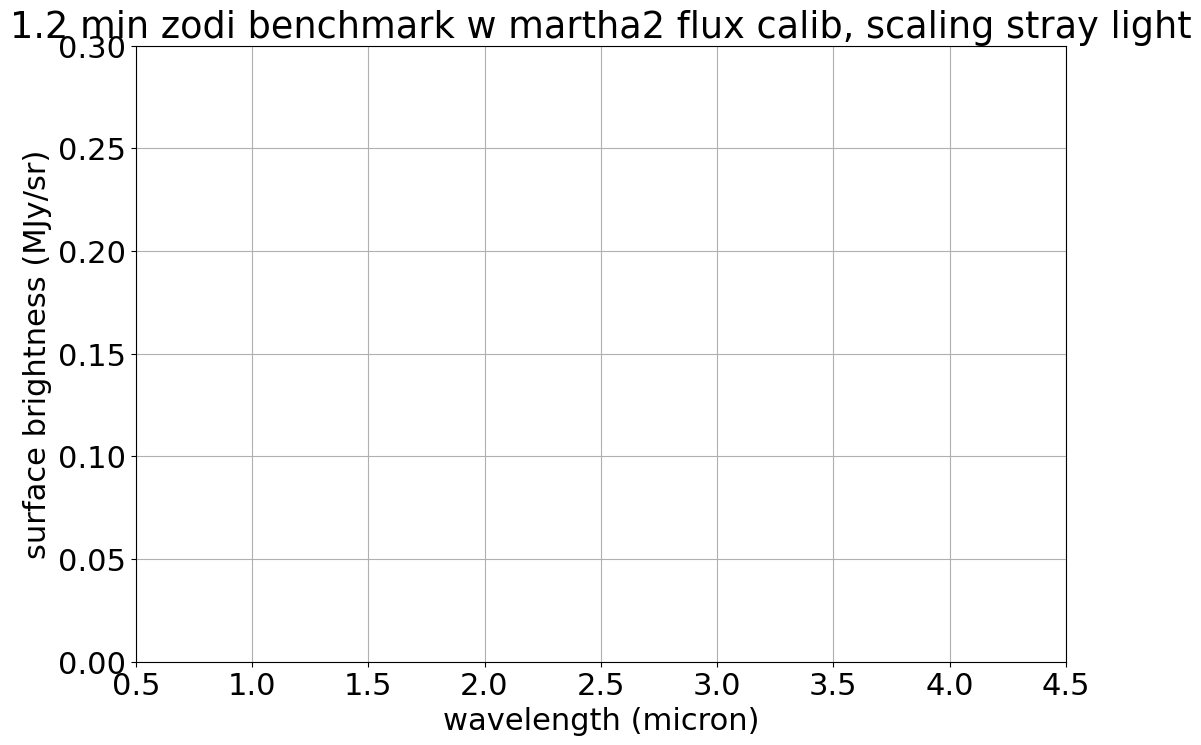

In [151]:
# Make a simple animation of the 1.2 min zody field, as I add more expected stray light
# PLOT EVERYTHING!
fig = plt.figure()   ; camera = Camera(fig)
x1=0.5; x2=4.5
y1=0.0; y2=0.3 
plt.rcParams['figure.figsize'] = [12, 8]
statcol = 'sb_mjsr'
scale_straylight = 0.1
thisobsname = '1.2 min zodi benchmark'
thisobs = dict_obs[thisobsname]
print(thisobsname, thisobs)
sub1_1 = grab_subset_df(grouped1_df1, thisobs)
sub1_2 = grab_subset_df(grouped1_df2, thisobs)
sub2_1 = grab_subset_df(grouped2_df1, thisobs)
sub2_2 = grab_subset_df(grouped2_df2, thisobs)
for scale_straylight in np.linspace(0, 1.5, num=15) :
    print(str(scale_straylight))
    plot_dfs_new(sub1_1, sub1_2, sub2_1, sub2_2, statcol='sb_mjsr', annotate=False)
    plt.title(thisobsname + " w " + whos_fluxing + " flux calib, scaling stray light")
    plt.annotate("scaling stray light by "+str(np.round(scale_straylight, 1)), (3, 0.28))
    plt.scatter((2.0, 3.0), (0.091, 0.07), color='green', label='Stray light requirements', s=100)
    prefix = from_PID_observtn_to_prefix(pid, thisobs[0]) 
    jrr.jwst.plot_expected_bkgs(bkg_df[prefix], scalestray=scale_straylight, plotlegend=False)
    plt.xlim(x1, x2)
    plt.ylim(y1, y2) 
    plt.xlabel("wavelength (micron)")
    plt.ylabel("surface brightness (MJy/sr)")
#    plt.show()
    camera.snap()
animation=camera.animate()
animation.save('scale_straylight_12minzody.gif', dpi=100, fps=2)

Galactic bulge (1, 9) jw01448001


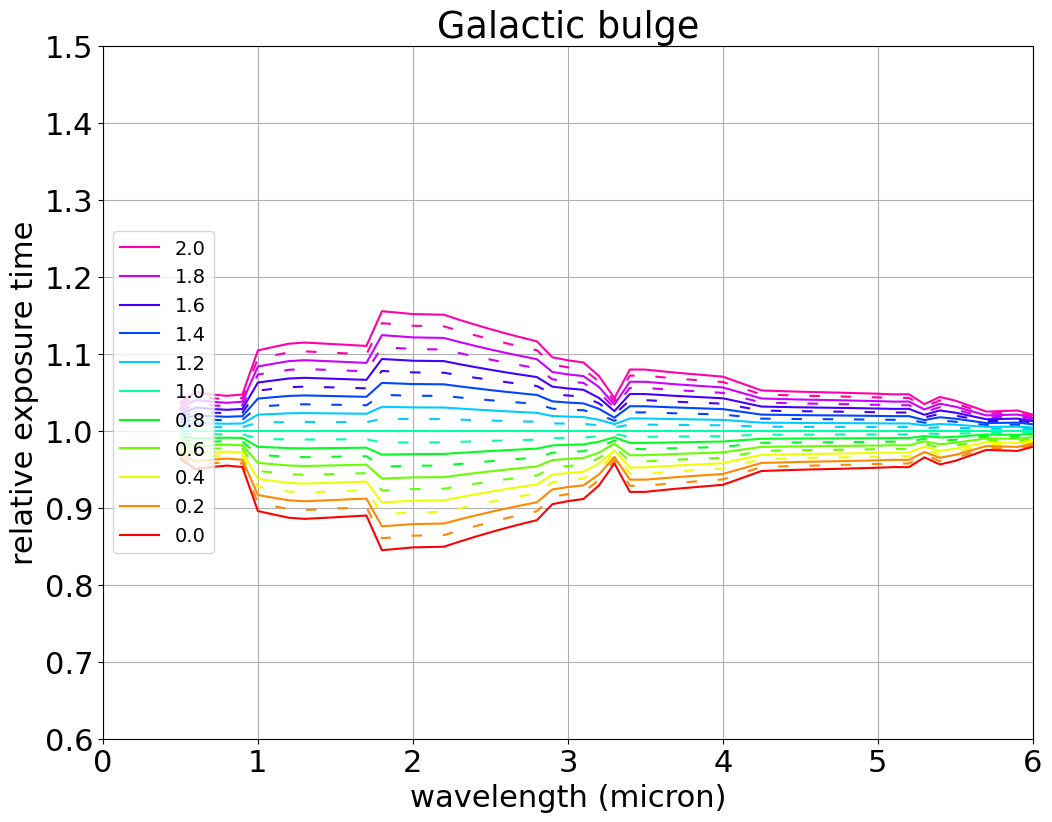

Low bkg 1 (2, 12) jw01448002


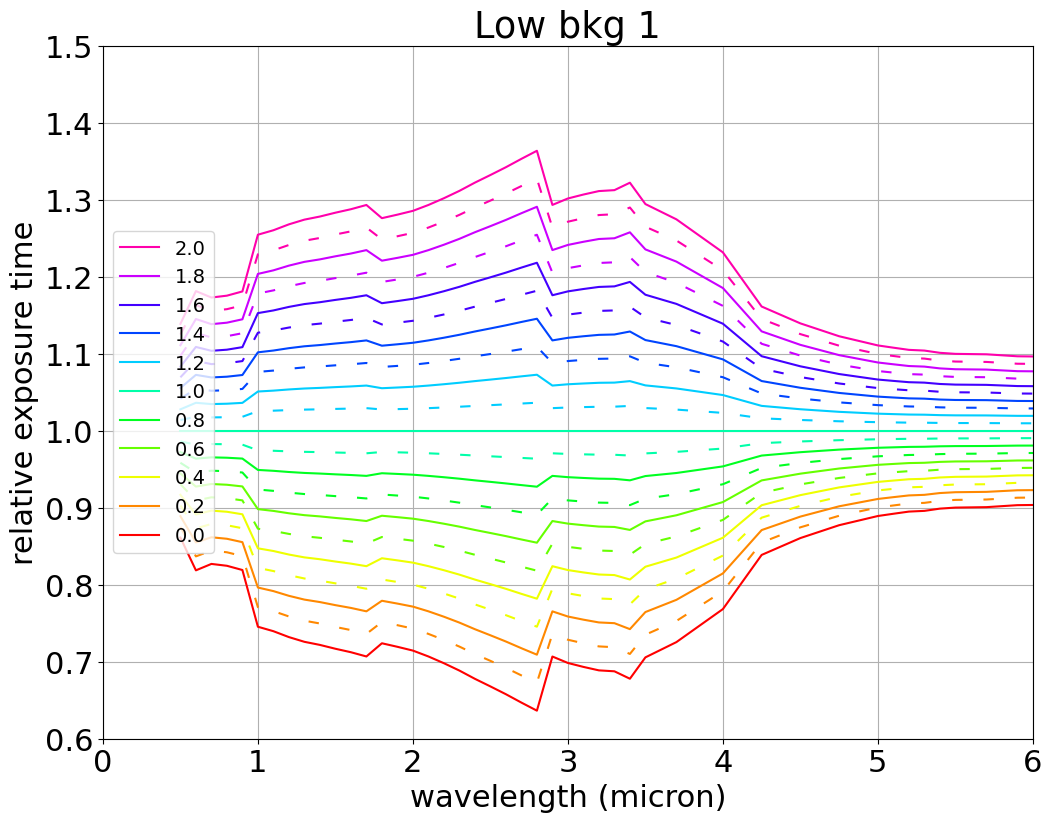

LB2-EGS-N (3, 13) jw01448003


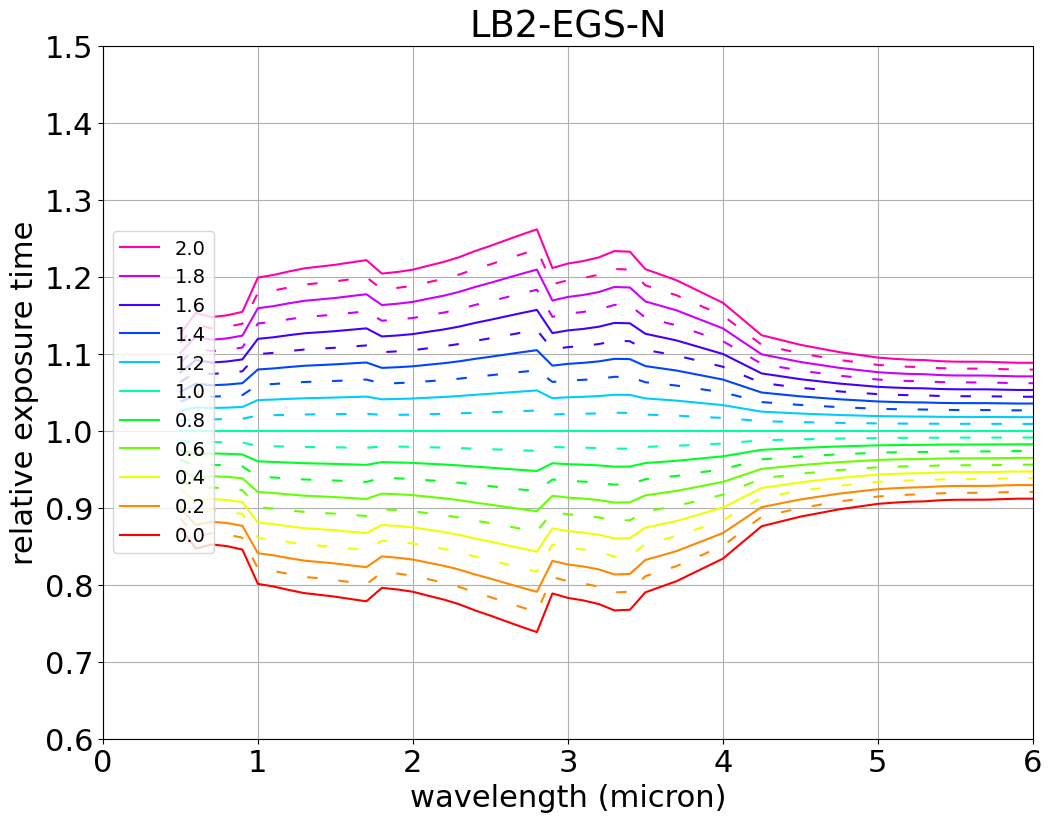

Low bkg 3 (4, 14) jw01448004


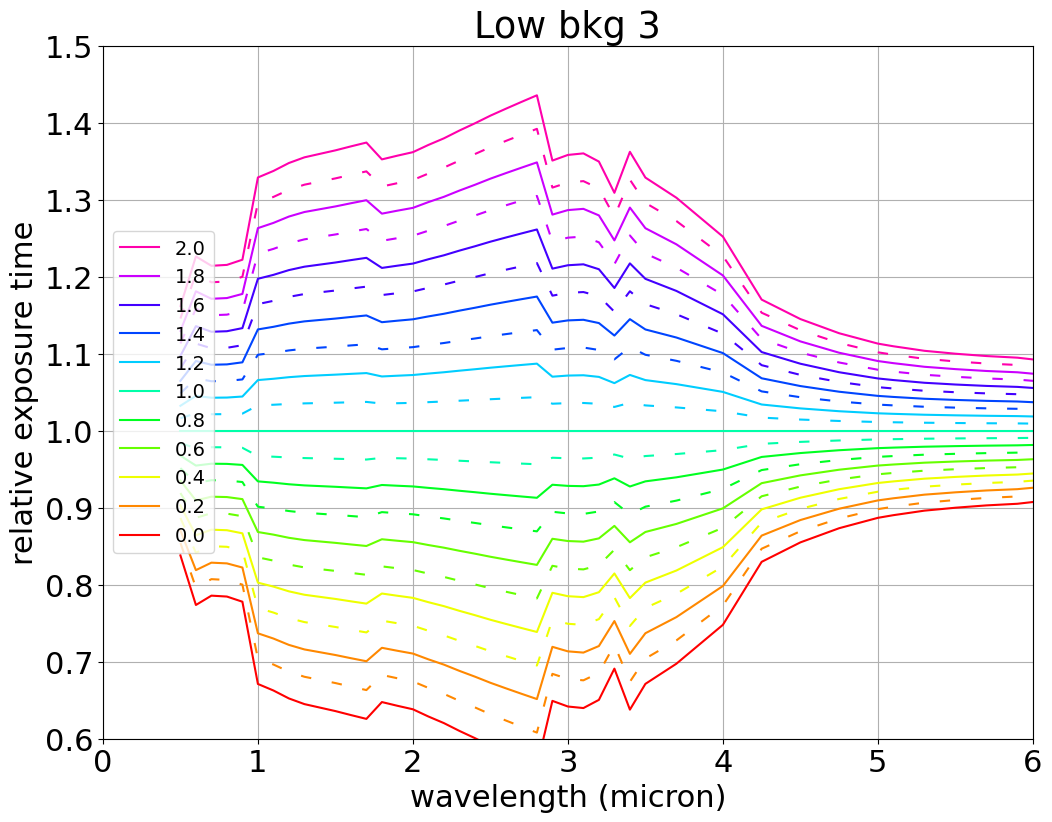

1.2 min zodi benchmark (5, 15, 11) jw01448005


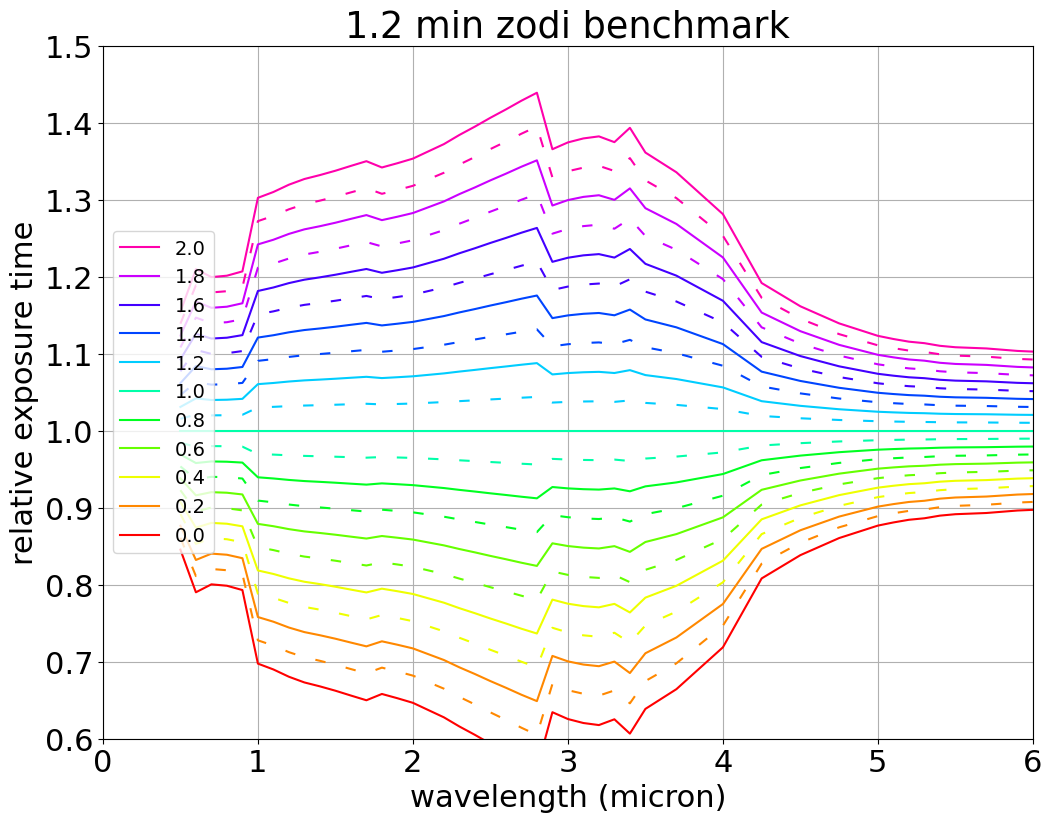

CVZ-S (6, 16, 10) jw01448006


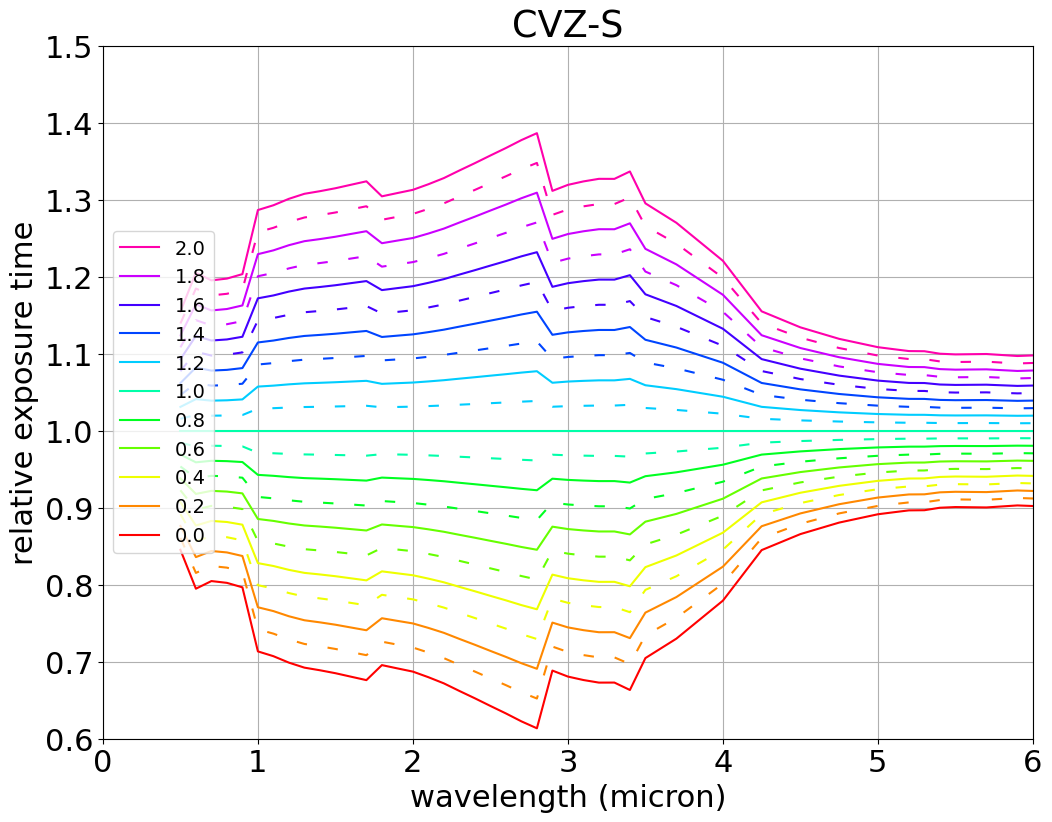

High Zodi (7,) jw01448007


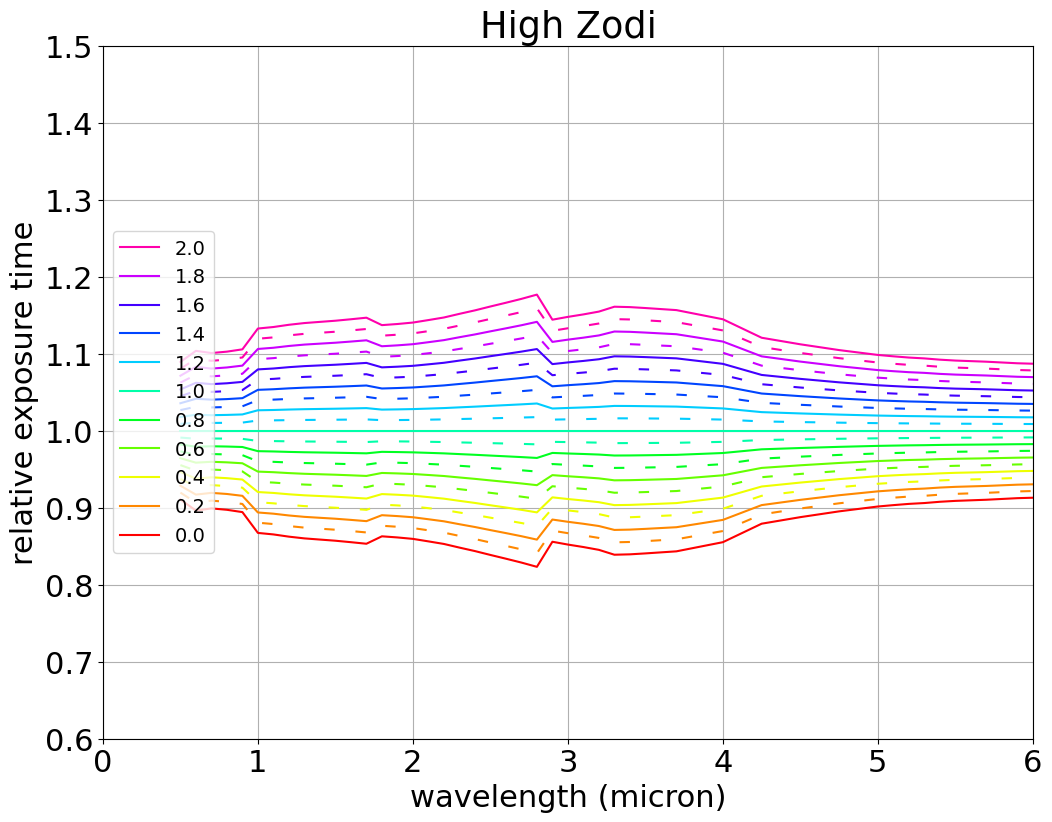

Moderate bkg (8,) jw01448008


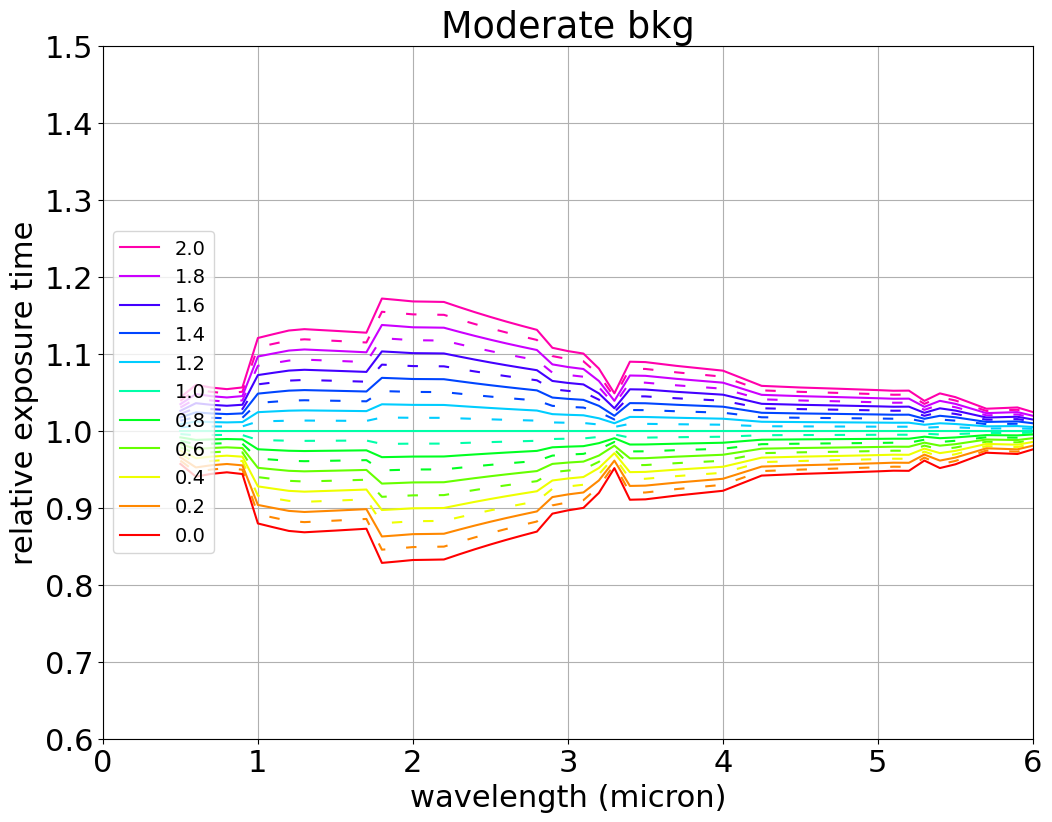

Plotting how the relative exposure time varies as a function of the strength of
the stray light component compared to PREDICTIONS, from  0.0 to 2.0 times
what was predicted pre-launch


In [152]:
# Let's make an illustrative plot about how changes in bkg affect exposure time, for
# the background limited case.  Use EGS as a nice low bkg field.
plt.rcParams['figure.figsize'] = [12, 9]
pp = PdfPages("straylight_building_intuition.pdf")  # output 

cmap = plt.get_cmap('hsv')
colors = cmap(np.linspace(0.9,0,11)) #get N colors along the full range of hsv colormap
linestyles = ['solid' , (0, (5, 10))]#, 'dotted'] 
plt.rc('axes', prop_cycle=(cycler('color', colors) * cycler('linestyle', linestyles))) 

#obsnames = ('1.2 min zodi benchmark', 'LB2-EGS-N')
#for thisobsname in obsnames:   
for thisobsname, thisobs in (sorted(dict_obs.items(), key=lambda x:x[1])):

    thisobs = dict_obs[thisobsname]
    prefix = from_PID_observtn_to_prefix(pid, thisobs[0])
    print(thisobsname, thisobs, prefix)
    df = bkg_df[prefix]

    # Set up some colors
    fig, ax = plt.subplots()

    scale1=0.0;  scale2=2.0
    for scaleby in np.linspace(scale2, scale1, 21) :
        df['new'] = df['total'] + df['straylight'] * (scaleby - 1)
        df['ratio'] = df['new'] / df['total']
        label = np.round(scaleby,2)
        if label*10 %2 : label = '_nolegend_' 
        df.plot(x='wave', y='ratio', label=str(label), lw=1.5, ax=ax)
    plt.xlim(0,6) ; plt.ylim(0.6,1.5)
    plt.xlabel("wavelength (micron)")
    plt.ylabel("relative exposure time")
    plt.title(thisobsname)
    plt.legend(fontsize=14, loc='center left')
    plt.grid()
    pp.savefig()
    plt.show()
pp.close()

print("Plotting how the relative exposure time varies as a function of the strength of")
print("the stray light component compared to PREDICTIONS, from ", scale1, "to", scale2, "times")
print("what was predicted pre-launch")


In [153]:
# Next, I should repeat, but compared to REQUIREMENTS.  Do this for the 1.2 min zody field.
dict_obs

{'Galactic bulge': (1, 9),
 'Low bkg 1': (2, 12),
 'LB2-EGS-N': (3, 13),
 'Low bkg 3': (4, 14),
 '1.2 min zodi benchmark': (5, 15, 11),
 'CVZ-S': (6, 16, 10),
 'High Zodi': (7,),
 'Moderate bkg': (8,)}

In [154]:
tmpfile = 'straylightcar_predictedbkg_visitjw01448006.txt'
df_bkg = jrr.jwst.open_background_file(tmpfile)
df_bkg.head()

,wave,total,zody,Gal,straylight,thermal
0,0.5,0.1319,0.1084,0.0031,0.0204,0.0
1,0.6,0.1857,0.1432,0.0044,0.0381,0.0
2,0.7,0.2064,0.1608,0.0053,0.0403,0.0
3,0.8,0.2146,0.1659,0.0062,0.0424,0.0
4,0.9,0.2129,0.1630,0.0066,0.0433,0.0


In [155]:
# Pseudo code:  for each measured background, go look up what the all non-thermal emission *should have been, and subtract it off.
# Write fcn that does this once, then .map() or .apply()